##Approach 3

Using % Diabetic to Select Features

In [30]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import os
import re
import scipy.stats as scs
from scipy import spatial
import sklearn
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from patsy import dmatrices
import seaborn as sns

In [31]:
os.chdir('/Users/ItelinaMa/Documents/Metis/McNulty/trainingSet')
diagnosisT = pd.read_csv('training_SyncDiagnosis.csv')
allergyT = pd.read_csv('training_SyncAllergy.csv')
immunT = pd.read_csv('training_SyncImmunization.csv')
labObsT = pd.read_csv('training_SyncLabObservation.csv')
labPanT = pd.read_csv('training_SyncLabPanel.csv')
labResT = pd.read_csv('training_SyncLabResult.csv')
medicationT = pd.read_csv('training_SyncMedication.csv')
patientT = pd.read_csv('training_SyncPatient.csv')
patientCondT = pd.read_csv('training_SyncPatientCondition.csv')
smokingT = pd.read_csv('training_SyncPatientSmokingStatus.csv')
prescripT = pd.read_csv('training_SyncPrescription.csv')
trnscrpT = pd.read_csv('training_SyncTranscript.csv')
trnscrpAT = pd.read_csv('training_SyncTranscriptAllergy.csv')
trnscrpDT = pd.read_csv('training_SyncTranscriptDiagnosis.csv')
trnscrptMT = pd.read_csv('training_SyncTranscriptMedication.csv')
myfileT = pd.read_csv('myfile.csv', header=None)
conditionT = pd.read_csv('SyncCondition.csv')
smokingT = pd.read_csv('SyncSmokingStatus.csv')

#Section 1. Data Procession

BMI, Blood Pressure, Diseases

In [32]:
def makeBMI():
    trnscrpT['BMI'] = trnscrpT['BMI'].replace(0.000, np.nan)
    bmi1 = trnscrpT.groupby(['PatientGuid'])['BMI'].mean()
    bmi2 = trnscrpT.groupby(['PatientGuid'])['BMI'].max()
    bmi3 = trnscrpT.groupby(['PatientGuid'])['BMI'].min()
    bmi = pd.concat([bmi1, bmi2, bmi3], axis = 1)
    bmi.columns = ['MeanBMI', 'MaxBMI', 'MinBMI']
    bmi['isOverweight'] = 0
    bmi['isObese'] = 0
    bmi.loc[(bmi['MeanBMI'] >= 25) & (bmi['MeanBMI'] < 30), 'isOverweight'] = 1
    bmi.loc[bmi['MeanBMI'] >= 30, 'isObese'] = 1
    bmi['BMIDiff'] = np.abs(bmi['MaxBMI'] - bmi['MinBMI'])
    bmi = bmi.reset_index()
    return bmi

In [33]:
def makeBP():
    bloodpressure1 = trnscrpT.groupby(['PatientGuid'])[['SystolicBP', 'DiastolicBP']].mean()
    bloodpressure2 = trnscrpT.groupby(['PatientGuid'])[['SystolicBP', 'DiastolicBP']].max()
    bloodpressure3 = trnscrpT.groupby(['PatientGuid'])[['SystolicBP', 'DiastolicBP']].min()
    bloodpressure = pd.concat([bloodpressure1, bloodpressure2, bloodpressure3], axis = 1)
    bloodpressure.columns = ['meanSystolicBP', 'meanDiastolicBP', 'maxSystolicBP', 'maxDiastolicBP', 'minSystolicBP', 'minDiastolicBP']
    bloodpressure['SystDiff'] = np.abs(bloodpressure['maxSystolicBP'] - bloodpressure['minSystolicBP'])
    bloodpressure['DiastDiff'] = np.abs(bloodpressure['maxDiastolicBP'] - bloodpressure['minDiastolicBP'])
    bloodpressure['isPreHyp'] = 0
    bloodpressure['isStage1HBP'] = 0
    bloodpressure['isStage2HBP'] = 0
    bloodpressure.loc[((bloodpressure['meanSystolicBP'] >= 120) & (bloodpressure['meanSystolicBP'] < 140)) | ((bloodpressure['meanDiastolicBP'] >= 80) & (bloodpressure['meanDiastolicBP'] < 90)), 'isPreHyp'] = 1
    bloodpressure.loc[((bloodpressure['meanSystolicBP'] >= 140) & (bloodpressure['meanSystolicBP'] < 160)) | ((bloodpressure['meanDiastolicBP'] >= 90) & (bloodpressure['meanDiastolicBP'] < 100)), 'isStage1HBP'] = 1
    bloodpressure.loc[(bloodpressure['meanSystolicBP'] >= 160) | (bloodpressure['meanDiastolicBP'] >= 100), 'isStage2HBP'] = 1
    bloodpressure.loc[bloodpressure['isStage2HBP'] == 1, 'isStage1HBP'] = 0
    bloodpressure.loc[bloodpressure['isStage1HBP'] == 1, 'isPreHyp'] = 0
    bloodpressure = bloodpressure.reset_index()
    return bloodpressure

In [34]:
def makeConditions():
    diaganalysis = pd.merge(patientT, diagnosisT, on=['PatientGuid'])
    chidata = diaganalysis[['PatientGuid', 'DMIndicator', 'ICD9Code']].drop_duplicates()
    chidata.index = chidata['PatientGuid']
    dummies = pd.get_dummies(chidata['ICD9Code']).reset_index()
    dummies = dummies.groupby(['PatientGuid'])[dummies.columns[1:]].sum()
    dummies = dummies.replace(2, 1)
    chidata = chidata[['PatientGuid', 'DMIndicator']]
    chidata = chidata.drop_duplicates()
    chidata = pd.concat([chidata, dummies], axis=1)
    chidata['DMIndicator'] = chidata['DMIndicator'].astype(float)
    return chidata

In [35]:
def heartDisease(text):
    if bool(re.match('41[0-4]|42[0-5]|427|429|74[5-6]', text)) == True:
        return 1
    return 0
def CAD(text):
    if bool(re.match('41[0-4]|429', text)) == True:
        return 1
    return 0
def cardiomyopathy(text):
    if bool(re.match('42[0-5]', text)) == True:
        return 1
    return 0
def CHF(text):
    if bool(re.match('426', text)) == True:
        return 1
    return 0
def arrhythmias(text):
    if bool(re.match('427', text)) == True:
        return 1
    return 0
def heartdefects(text):
    if bool(re.match('74[5-6]', text)) == True:
        return 1
    return 0
def stroke(text):
    if bool(re.match('43[0-1]|43[3-6]|997.02', text)) == True:
        return 1
    return 0
def sleepApnea(text):
    if bool(re.match('727.23|780.57', text)) == True:
        return 1
    return 0
def gestDiab(text):
    if bool(re.match('648.8', text)) == True:
        return 1
    return 0
def polyOvary(text):
    if bool(re.match('256.4', text)) == True:
        return 1
    return 0
def frozenShoulder(text):
    if bool(re.match('726.0', text)) == True:
        return 1
    return 0
def hemochr(text):
    if bool(re.match('275.03', text)) == True:
        return 1
    return 0
def hepatitis(text):
    if bool(re.match('070.2|070.3', text)) == True:
        return 1
    return 0
def diabCompl(text):
    if bool(re.match('250.[1-3]|250.5|250.8|251.[0-2]|270.3|775.6|962.3', text)) == True:
        return 1
    return 0
def kidneyFailure(text):
    if bool(re.match('58[4-5]', text)) == True:
        return 1
    return 0
def dementia(text):
    if bool(re.match('331|290|294|797', text)) == True:
        return 1
    return 0
def acanthosis(text):
    if bool(re.match('701.2', text)) == True:
        return 1
    return 0
def blindness(text):
    if bool(re.match('369', text)) == True:
        return 1
    return 0
def sDysfunction(text):
    if bool(re.match('302.7', text)) == True:
        return 1
    return 0
def preDiabetes(text):
    if bool(re.match('790.29', text)) == True:
        return 1
    return 0

In [36]:
def ICD9Label(text):
    if bool(re.match('14[0-9]|2[0-3][0-9]', text)) == True:
        return 'neoplasms'
    elif bool(re.match('2[4-7][0-9]', text)) == True:
        return 'endoctrine'
    elif bool(re.match('28[0-9]', text)) == True:
        return 'blood'
    elif bool(re.match('29[0-9]|3[0-1][0-9]', text)) == True:
        return 'mental'
    elif bool(re.match('3[2-5][0-9]', text)) == True:
        return 'nervous'
    elif bool(re.match('3[6-8][0-9]', text)) == True:
        return 'sense'
    elif bool(re.match('39[0-9]|4[0-5][0-9]', text)) == True:
        return 'circulatory'
    elif bool(re.match('4[6-9][0-9]|5[0-1][0-9]', text)) == True:
        return 'respiratory'
    elif bool(re.match('5[2-7][0-9]', text)) == True:
        return 'digestive'
    elif bool(re.match('5[8-9][0-9]|6[0-2][0-9]', text)) == True:
        return 'genitourinary'
    elif bool(re.match('6[3-7][0-9]', text)) == True:
        return 'pregnancy'    
    elif bool(re.match('6[8-9][0-9]|70[0-9]', text)) == True:
        return 'skin'   
    elif bool(re.match('7[1-3][0-9]', text)) == True:
        return 'musculoskeletal'       
    elif bool(re.match('7[4-5][0-9]', text)) == True:
        return 'congenital' 
    elif bool(re.match('7[6-7][0-9]', text)) == True:
        return 'perinatal' 
    elif bool(re.match('7[8-9][0-9]', text)) == True:
        return 'symptoms or ill-defined' 
    elif bool(re.match('8[0-9][0-9]|9[0-9][0-9]', text)) == True:
        return 'injuries' 
    elif bool(re.match('E|V', text)) == True:
        return 'suppl' 
    else:
        return 'infectious'

In [37]:
def stripPeriods(text):
    result = re.sub('\.', "", text)
    return result

In [38]:
def makeSpecials():
    data = diagnosisT.copy()
    data['ICD9'] = data['ICD9Code'].apply(stripPeriods)
    data['hasHeartDisease'] = data['ICD9Code'].apply(heartDisease)
    data['hasCAD'] = data['ICD9Code'].apply(CAD)
    data['hasCardiomyo'] = data['ICD9Code'].apply(cardiomyopathy)
    data['hasArrhy'] = data['ICD9Code'].apply(arrhythmias)
    data['hasHeartDefects'] = data['ICD9Code'].apply(heartdefects)
    data['hasCHF'] = data['ICD9Code'].apply(CHF)
    data['hasStroke'] = data['ICD9Code'].apply(stroke)
    data['hasSleepA'] = data['ICD9Code'].apply(sleepApnea)
    data['hasGestDiab'] = data['ICD9Code'].apply(gestDiab)
    data['hasPolyO'] = data['ICD9Code'].apply(polyOvary)
    data['hasFrozenShoulder'] = data['ICD9Code'].apply(frozenShoulder)
    data['hasHemoChr'] = data['ICD9Code'].apply(hemochr)
    data['hasHepatitis'] = data['ICD9Code'].apply(hepatitis)
    data['hasDiabComp'] = data['ICD9Code'].apply(diabCompl)
    data['hasKidneyF'] = data['ICD9Code'].apply(kidneyFailure)
    data['hasDementia'] = data['ICD9Code'].apply(dementia)
    data['hasAcanthosis'] = data['ICD9Code'].apply(acanthosis)
    data['hasBlindness'] = data['ICD9Code'].apply(blindness)
    data['hasSDysf'] = data['ICD9Code'].apply(sDysfunction)
    data['hasPreDiab'] = data['ICD9Code'].apply(preDiabetes)
    diagnosisSummary = data.groupby(['PatientGuid'])[['hasHeartDisease', 'hasCHF', 'hasStroke', 'hasSleepA', 'hasGestDiab','hasPolyO', 'hasFrozenShoulder', 'hasHemoChr','hasHepatitis', 'hasDiabComp', 'hasKidneyF', 'hasDementia','hasAcanthosis', 'hasBlindness' ,'hasSDysf', 'hasPreDiab']].max()
    diagnosisSummary = diagnosisSummary.reset_index()
    return diagnosisSummary

In [39]:
def getPatientAge():
    data=patientT.copy()
    data.drop('PracticeGuid', axis=1, inplace=True)
    data.drop('State', axis=1, inplace=True)
    data['Age'] = 2015 - data['YearOfBirth']
    data.drop('YearOfBirth', axis=1, inplace=True)
    return data

In [40]:
def makeICD9Labels():
    data = diagnosisT.copy()
    data['ICD9Label'] = data['ICD9Code'].apply(ICD9Label)
    data['Counts'] = 1
    ICD9Labeldata = data.groupby(['PatientGuid', 'ICD9Label'])['Counts'].max().reset_index().pivot('PatientGuid', 'ICD9Label', 'Counts').reset_index()
    ICD9Labeldata = ICD9Labeldata.fillna(0)
    return ICD9Labeldata

In [41]:
bloodpressure = makeBP()
bmi = makeBMI()
conditions = makeConditions()
specials = makeSpecials()
patients = getPatientAge()
icd9lab = makeICD9Labels()

In [42]:
def makeSimilarity():
    columns = conditions.columns[2:]
    chitest = {}
    cmatrix = {}
    cos = {}
    percent = {}
    for column in columns:
        cm = confusion_matrix(np.array(conditions['DMIndicator']), np.array(conditions[column]))
        cmatrix[column] = cm
        chitest[column]= scs.chi2_contingency(cm)[1]
        cos[column] = 1 - spatial.distance.cosine(conditions['DMIndicator'], conditions[column])
        percent[column] = [float(cm[1][1])/(float(cm[0][1]) + float(cm[1][1])), (float(cm[0][1]) + float(cm[1][1]))]
    return cos, chitest, cmatrix, percent

In [43]:
perc = makeSimilarity()[3]

In [44]:
cos = makeSimilarity()[0]

In [24]:
len(conditions.PatientGuid.unique())

9948

In [61]:
diagnames = diagnosisT[['ICD9Code', 'DiagnosisDescription']].drop_duplicates()
diagnames.index = diagnames['ICD9Code']
diagnames = diagnames['DiagnosisDescription']

In [62]:
diagnames.head(5)

ICD9Code
825.0                         Fracture of calcaneus, closed
784.0                                              Headache
461.9                          Acute sinusitis, unspecified
V72.31                    Routine gynecological examination
345.90    Epilepsy, unspecified, without mention of intr...
Name: DiagnosisDescription, dtype: object

In [64]:
output1 = pd.DataFrame(data=perc).T
output1.columns = ['PercentageDiab', 'PatientsWithCondition']
output1['PercentageOfTotalPop'] = output1['PatientsWithCondition']/9948
output1 = output1.sort('PatientsWithCondition', ascending=False)
output2 = pd.concat([diagnames, output1], axis=1).reset_index()
output2.head(5)

,index,DiagnosisDescription,PercentageDiab,PatientsWithCondition,PercentageOfTotalPop
0,002.0,Typhoid fever,1.0,1,0.000101
1,003.0,Salmonella gastroenteritis,0.5,2,0.000201
2,003.23,Salmonella arthritis,0.0,1,0.000101
3,005.9,"Food poisoning, unspecified",0.0,4,0.000402
4,007.1,Giardiasis,0.0,4,0.000402


In [65]:
output2.to_csv('visualization.csv')

In [15]:
def getICD9(threshold=0.2):
    ICD9 = []
    for key in perc.keys():
        if perc[key][0] > threshold:
            ICD9.append(key)
    return ICD9

In [16]:
print bloodpressure.shape, bmi.shape, specials.shape, patients.shape, conditions.shape, icd9lab.shape

(9948, 12) (9948, 7) (9948, 17) (9948, 4) (9948, 3945) (9948, 20)


In [18]:
import sys
sys.setrecursionlimit(10000)

In [28]:
def optimizer():
    Metric = []
    threshold = []

    patientdata = pd.merge(patients, specials, how='inner', on =['PatientGuid'])
    patientdata = pd.merge(patientdata, icd9lab, how='inner', on =['PatientGuid'])
    patientdata = pd.merge(patientdata, bloodpressure, how='inner', on =['PatientGuid'])
    patientdata = pd.merge(patientdata, bmi, how='inner', on =['PatientGuid'])

    for i in list(np.arange(0.1, max(perc.values()), 0.05)):
        #piece together the datasets
        ICD9 = getICD9(i)
        newconditions = pd.concat([conditions['PatientGuid'], conditions[ICD9]], axis=1)
        patientdata = pd.merge(patientdata, newconditions, how='inner', on =['PatientGuid'])
        
        #create model variables
        modelelements = '") + Q("'.join(patientdata.columns[2:])
        modelelements = 'Q("' + modelelements + '")'
        formula = 'DMIndicator ~ ' + modelelements
        y, X = dmatrices(formula, data=patientdata, return_type='dataframe')
        X = X.drop('Intercept', 1)

        #setting up test train split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)
        X_train = np.array(X_train)
        X_test = np.array(X_test)
        y_train = np.array(y_train).ravel()
        y_test = np.array(y_test).ravel()
    
        #run logistic regression
        n_samples = X_train.shape[0]
        model1 = LogisticRegression()
        #model1.fit(X_train, y_train)
        #y_pred_proba = model1.predict_proba(X_test)
        cv = sklearn.cross_validation.ShuffleSplit(n_samples, n_iter=10, test_size=0.2, random_state=1)
        metric = sklearn.cross_validation.cross_val_score(model1, X_train, y_train, cv=cv, scoring='recall')
        mmetric = metric.mean()
        #fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_pred_proba[:,1])
        #auc = sklearn.metrics.auc(fpr, tpr
        #logloss = sklearn.metrics.log_loss(y_test, y_pred_proba[:,1])
        
        threshold.append(i)
        Metric.append(mmetric)
        
    return threshold, Metric

In [ ]:
threshold, recall = optimizer()

In [ ]:
bestthreshold = threshold[AUC.index(max(recall))]
bestthreshold

In [ ]:
%matplotlib inline
matplotlib.style.use('ggplot')
plt.plot(threshold, AUC)
plt.show()

In [19]:
def makeData(threshold = 0.2):
    ICD9 = getICD9(threshold)
    newconditions = pd.concat([conditions['PatientGuid'], conditions[ICD9]], axis=1)
    patientdata = pd.merge(patients, newconditions, how='inner', on =['PatientGuid'])
    patientdata = pd.merge(patientdata, specials, how='inner', on =['PatientGuid'])
    patientdata = pd.merge(patientdata, icd9lab, how='inner', on =['PatientGuid'])
    patientdata = pd.merge(patientdata, bloodpressure, how='inner', on =['PatientGuid'])
    patientdata = pd.merge(patientdata, bmi, how='inner', on =['PatientGuid'])

    #create model variables
    modelelements = '") + Q("'.join(patientdata.columns[2:])
    modelelements = 'Q("' + modelelements + '")'
    formula = 'DMIndicator ~ ' + modelelements
    y, X = dmatrices(formula, data=patientdata, return_type='dataframe')
    X = X.drop('Intercept', 1)

    #setting up test train split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train).ravel()
    y_test = np.array(y_test).ravel()
    
    columns = X.columns
    
    return X_train, y_train, X_test, y_test, columns

In [20]:
X_train, y_train, X_test, y_test, features = makeData()

In [21]:
len(features)

1689

Accuracy: Training (CV)

In [22]:
n_samples = X_train.shape[0]
model1 = LogisticRegression()
cv = sklearn.cross_validation.ShuffleSplit(n_samples, n_iter=10, test_size=0.3, random_state=1)
scores = sklearn.cross_validation.cross_val_score(model1, X_train, y_train, cv=cv)
print scores.mean()

0.817420435511


Accuracy: Test

In [23]:
model1.fit(X_train, y_train)
model1.score(X_test, y_test)

0.82010050251256283

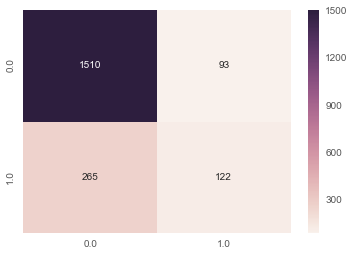

In [24]:
%matplotlib inline
matplotlib.style.use('ggplot')
y_pred = model1.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
labelname = model1.classes_
sns.heatmap(cm, annot=True,  fmt='', xticklabels=labelname, yticklabels=labelname)

Classification Report

In [25]:
report = classification_report(y_test.ravel(), y_pred)
print report

             precision    recall  f1-score   support

        0.0       0.85      0.94      0.89      1603
        1.0       0.57      0.32      0.41       387

avg / total       0.80      0.82      0.80      1990



ROC

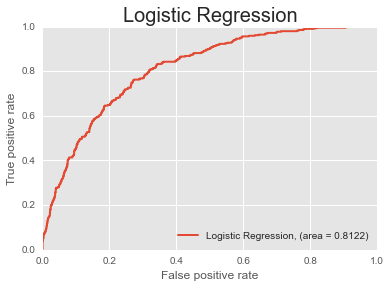

In [26]:
y_pred_proba = model1.predict_proba(X_test)
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_pred_proba[:,1])
roc_rates = [fpr, tpr]
auc = sklearn.metrics.auc(fpr, tpr)
plt.title("Logistic Regression", fontsize = 20)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
labelname = "Logistic Regression" + ", (area = %0.4f)" % auc
plt.plot(roc_rates[0], roc_rates[1], linewidth = 2, label = labelname)
plt.legend(loc = 4)

Log Loss: Testing

In [27]:
sklearn.metrics.log_loss(y_test, y_pred_proba[:,1])

0.39609237306299866